# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2023/11/09<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import keras
from keras import layers
import keras_tuner as kt
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [ ]:
path_honda = 'drive/MyDrive/CS114/Public/Honda'
path_suzuki = 'drive/MyDrive/CS114/Public/Suzuki'
path_yamaha = 'drive/MyDrive/CS114/Public/Yamaha'
path_vinfast = 'drive/MyDrive/CS114/Public/VinFast'
path_others = 'drive/MyDrive/CS114/Public/Others'


def getAllFiles(path, hangxe):
  allFiles = []

  for _, _, files in os.walk(path):
    for file in files:
      allFiles.append(os.path.join(hangxe, file))

  return allFiles

df_honda = pd.DataFrame(getAllFiles(path_honda, 'Honda'))
df_suzuki = pd.DataFrame(getAllFiles(path_suzuki, 'Suzuki'))
df_yamaha = pd.DataFrame(getAllFiles(path_yamaha, 'Yamaha'))
df_vinfast = pd.DataFrame(getAllFiles(path_vinfast, 'VinFast'))
df_others = pd.DataFrame(getAllFiles(path_others, 'Others'))

In [ ]:
df_honda.columns = ['filename']
df_suzuki.columns = ['filename']
df_yamaha.columns = ['filename']
df_vinfast.columns = ['filename']
df_others.columns = ['filename']

In [ ]:
# Đường dẫn tới thư mục chứa ảnh
image_dir = 'drive/MyDrive/CS114/Public'

# Đường dẫn tới tệp CSV
csv_file = os.path.join(image_dir, 'MotocycleDataset-Splits-1-Train.csv')

# Đọc tệp CSV
df = pd.read_csv(csv_file, header=None, names=['filename', 'label'])

# Xóa các tên file không tồn tại
combined_df = pd.concat([df_honda, df_suzuki, df_yamaha, df_vinfast, df_others]).drop_duplicates()
df = df[df['filename'].isin(combined_df['filename'])]

valid_extensions = ('jpg', 'jpeg', 'png', 'gif', 'bmp')
df = df[df['filename'].str.endswith(valid_extensions, na=False)]

# Tạo danh sách đường dẫn ảnh và nhãn

filepaths = pd.DataFrame([os.path.join(image_dir, filename) for filename in df['filename']])
labels = df['label']

In [ ]:
df.tail()

,filename,label
28037,Others/22520033-22520035-22520083-22520148-225...,0
28038,Others/22520033-22520035-22520083-22520148-225...,0
28039,Others/22520033-22520035-22520083-22520148-225...,0
28040,Others/22520033-22520035-22520083-22520148-225...,0
28041,Others/22520033-22520035-22520083-22520148-225...,0


## Generate a `Dataset`

In [ ]:
# Tạo một TensorFlow Dataset từ danh sách đường dẫn và nhãn
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

In [ ]:
for data in dataset.take(100):
  print(data)

(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'drive/MyDrive/CS114/Public/Honda/22520968-22520996-22520999-22520929-22521373.Honda.786.jpg'],
      dtype=object)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'drive/MyDrive/CS114/Public/Honda/22520968-22520996-22520999-22520929-22521373.Honda.787.jpg'],
      dtype=object)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'drive/MyDrive/CS114/Public/Honda/22520968-22520996-22520999-22520929-22521373.Honda.788.jpg'],
      dtype=object)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'drive/MyDrive/CS114/Public/Honda/22520968-22520996-22520999-22520929-22521373.Honda.789.jpg'],
      dtype=object)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'drive/MyDrive/CS114/Public/Honda/22520968-22520996-22520999-22520929-22521373

## Visualize the data

Here are the first 9 images in the training dataset.

In [ ]:
# Hàm để đọc và xử lý ảnh từ filepaths
'''def load_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [180, 180])  # Resize ảnh về kích thước cố định
    return image, label'''

def load_image(filepath, label):
    try:
        image = tf.io.read_file(filepath)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)  # Automatically handles JPEG, PNG, etc.
        image = tf.image.resize(image, [180, 180])  # Resize image to fixed size
        return image, label
    except tf.errors.InvalidArgumentError as e:
        print(f"Error decoding image {filepath}: {e}")
        return None, label  # Return None for image and the original label

# Áp dụng hàm load_image lên dataset
dataset = dataset.map(load_image)

# Hàm để hiển thị ảnh từ dataset
def show_images_from_dataset(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
    plt.show()

In [ ]:
def show_images_from_dataset(dataset, num_images):
    plt.figure(figsize=(20, 20))
    images_shown = 0
    for images, labels in dataset:
        for i in range(len(images)):
            if images_shown >= num_images:
                break
            ax = plt.subplot(5, 10, images_shown + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
            images_shown += 1
        if images_shown >= num_images:
            break
    plt.show()
num_images_to_show = 50
show_images_from_dataset(dataset.batch(32), num_images_to_show)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Đếm tổng số phần tử trong dataset
dataset_size = len(filepaths)

# Xác định kích thước của train và eval datasets
train_size = int(0.8 * dataset_size)
eval_size = dataset_size - train_size

# Chia dataset thành train và eval datasets
train_dataset = dataset.take(train_size)
eval_dataset = dataset.skip(train_size)

# Batch datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
eval_dataset = eval_dataset.batch(batch_size)

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first few images in the dataset:

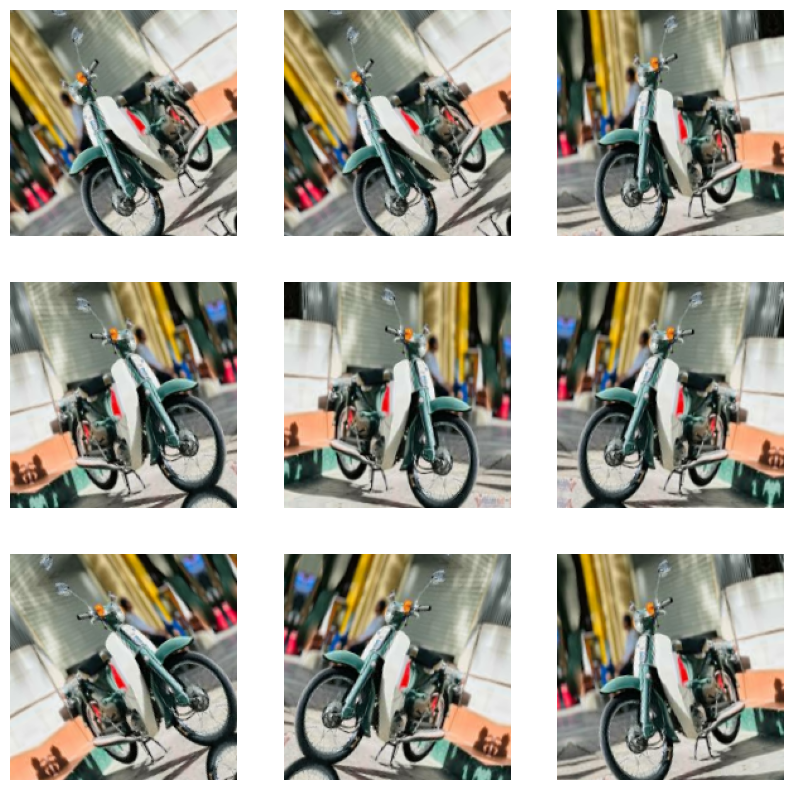

In [ ]:
plt.figure(figsize=(10, 10))
for images, label in dataset.take(10):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        augmented_images = tf.clip_by_value(augmented_images, 0, 255)
        augmented_images = tf.cast(augmented_images, tf.uint8)
        plt.imshow(augmented_images)
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [ ]:
# Apply `data_augmentation` to the training images.
train_dataset = train_dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE)
eval_dataset = eval_dataset.prefetch(tf_data.AUTOTUNE)

In [ ]:
train_dataset_temp = train_dataset
eval_dataset_temp = eval_dataset

In [ ]:
import tensorflow as tf
import numpy as np

def is_valid_image(filename):
    try:
        # Đọc và giải mã ảnh để kiểm tra định dạng
        image = tf.io.read_file(filename)
        image = tf.image.decode_image(image, channels=3)
        return True
    except tf.errors.InvalidArgumentError:
        return False

def filter_valid_images(filename, label):
    return tf.py_function(is_valid_image, [filename], [tf.bool])[0]

def load_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_image(image, channels=3)
    return image, label

def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        try:
            images.append(img_batch.numpy())
            labels.append(label_batch.numpy())
        except Exception as e:
            print(f"Error processing batch: {e}")
            print(f'img_batch: {img_batch}')
            continue  # Bỏ qua batch này và tiếp tục với batch tiếp theo
    return np.concatenate(images), np.concatenate(labels)

# Lọc bỏ các ảnh không hợp lệ
train_dataset_temp = train_dataset_temp.filter(filter_valid_images)
eval_dataset_temp = eval_dataset_temp.filter(filter_valid_images)

# Áp dụng hàm load_image để đọc và giải mã ảnh

# Batch và Prefetch để tăng tốc độ

# Chuyển đổi train_dataset thành x_train và y_train
x_train, y_train = dataset_to_numpy(train_dataset_temp)
x_val, y_val = dataset_to_numpy(eval_dataset_temp)

# Kiểm tra kích thước của dữ liệu
print("Train data shape:", x_train.shape, y_train.shape)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext] name: 

In [ ]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    try:
      for img_batch, label_batch in dataset:
          try:
              img_np = img_batch.numpy()
              label_np = label_batch.numpy()
              images.append(img_np)
              labels.append(label_np)
          except Exception as e:
              print(f"Error processing batch: {e}")
              print(f'img_batch: {img_batch}')
              continue  # Bỏ qua batch này và tiếp tục với batch tiếp theo
    except Exception as e:
        print(f"Error processing dataset: {e}")
        return None, None
    return np.concatenate(images), np.concatenate(labels)

# Chuyển đổi train_dataset thành x_train và y_train
x_train, y_train = dataset_to_numpy(train_dataset)

# Chuyển đổi eval_dataset thành x_val và y_val
x_val, y_val = dataset_to_numpy(eval_dataset)

# Kiểm tra kích thước của dữ liệu
print("\n\n\nTrain data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", x_val.shape, y_val.shape)

Error processing dataset: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext] name: 
Error processing dataset: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext] name: 


AttributeError: 'NoneType' object has no attribute 'shape'

## Build a model

We'll build a small version of the Xception network.

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

### Convolutional Neural Network

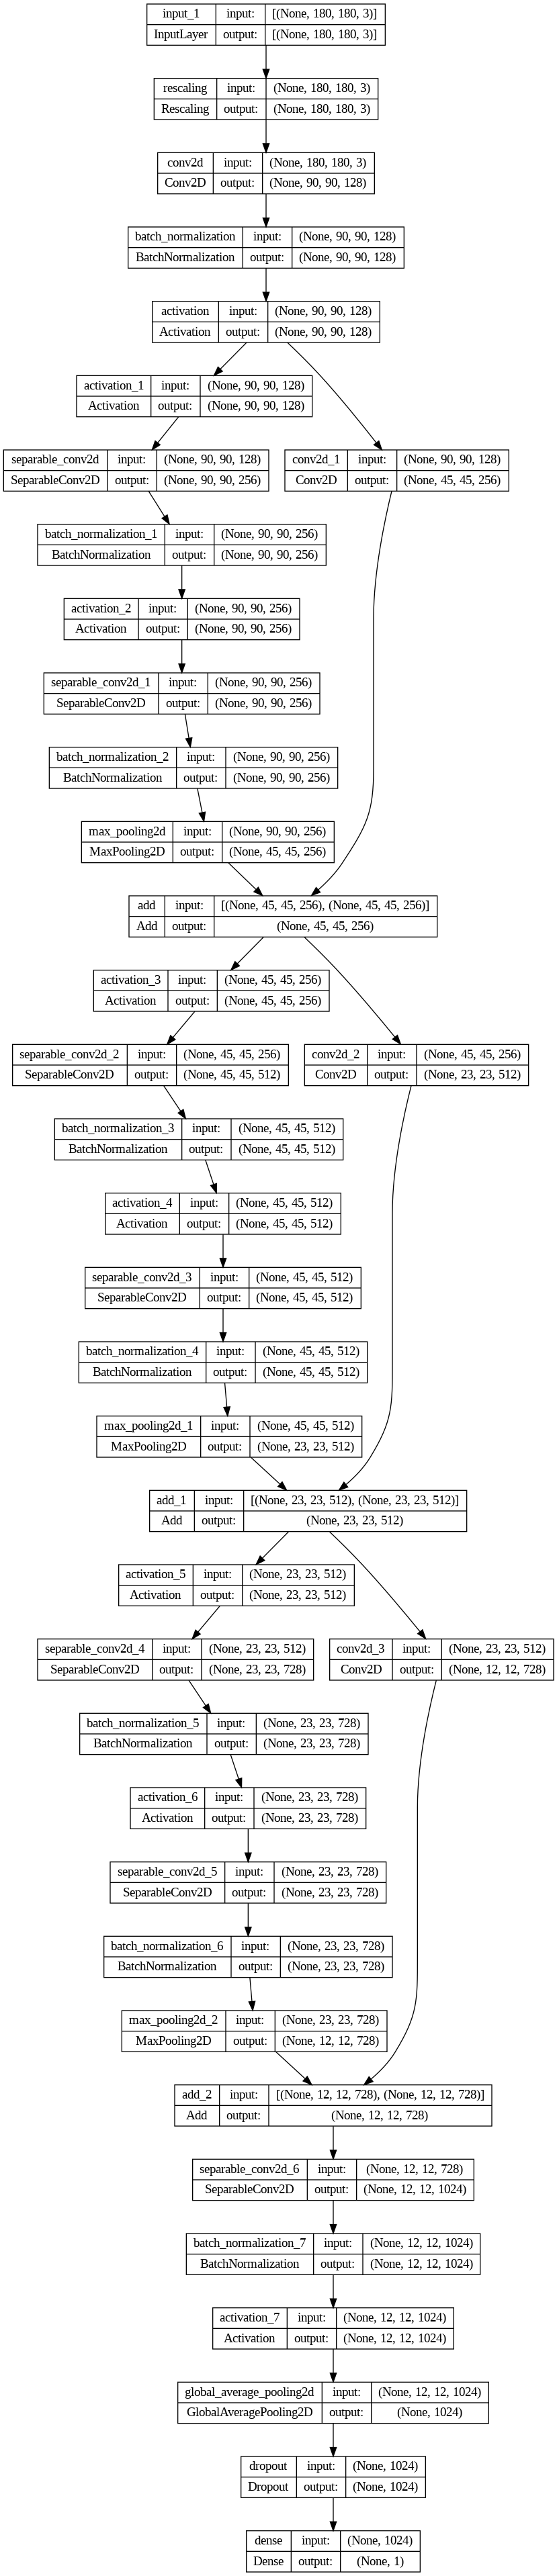

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

image_size = (180, 180)
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

### Xception Network

In [ ]:
def build_xception_model(hp):
    inputs = keras.Input(shape=(224, 224, 3))

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128, 256, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    for _ in range(8):
        residual = x
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(728, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(728, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(728, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, residual])

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(728, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(1024, 1, strides=2, padding="same")(previous_block_activation)
    x = layers.add([x, residual])

    x = layers.SeparableConv2D(1536, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.SeparableConv2D(2048, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units=hp.Int('units', min_value=10, max_value=1000, step=10), activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

## Train the model

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Hyperparameters tuning for Xception Network

In [ ]:
tuner = kt.RandomSearch(
    build_xception_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='xception_tuning')

# Perform the search for best hyperparameters
tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

model.save('drive/MyDrive/CS114/motocycleClassificationModel.h5')

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [ ]:
# Ví dụ mẫu trên dữ liệu dự đoán chó/ mèo
img = keras.utils.load_img("PetImages/Dog/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.backend.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.activations.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")